# 0. Import the Dataset

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("train.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


# 1 Plot Information

## Fertilizer Usage per Soil Type

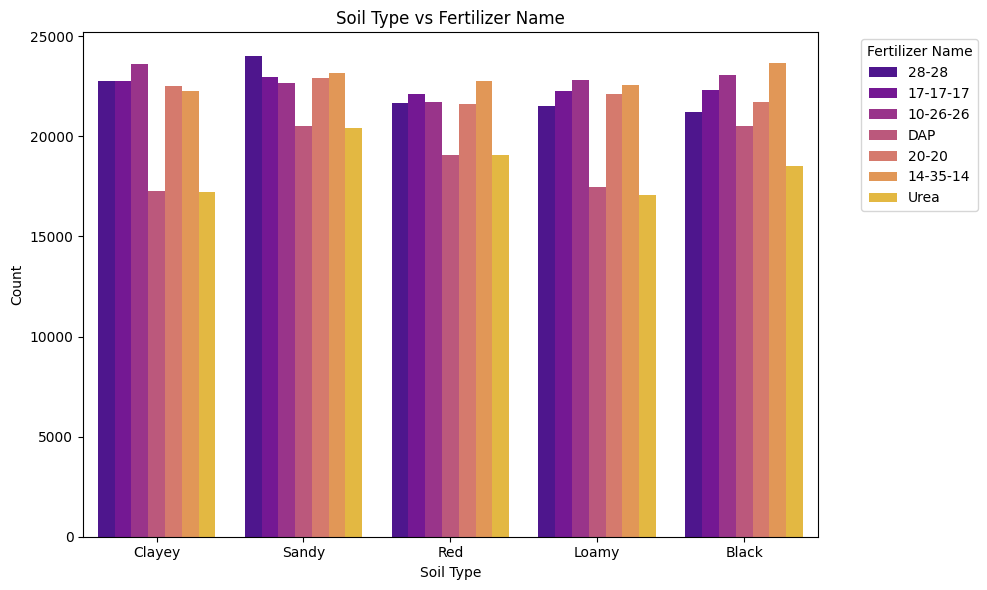

In [78]:
if 'Soil Type' in df.columns and 'Fertilizer Name' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Soil Type', palette='plasma', hue='Fertilizer Name')
    plt.title('Soil Type vs Fertilizer Name')
    plt.xlabel('Soil Type')
    plt.ylabel('Count')
    plt.legend(title='Fertilizer Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Most Used Fertilizer per Soil Type

In [79]:
if 'Soil Type' in df.columns and 'Fertilizer Name' in df.columns:
    most_used = df.groupby('Soil Type')['Fertilizer Name'].agg(lambda x: x.value_counts().idxmax())
    print('Most used fertilizer per soil type:')
    print(most_used)

Most used fertilizer per soil type:
Soil Type
Black     14-35-14
Clayey    10-26-26
Loamy     10-26-26
Red       14-35-14
Sandy        28-28
Name: Fertilizer Name, dtype: object


## Most Used Fertilizers Ranked

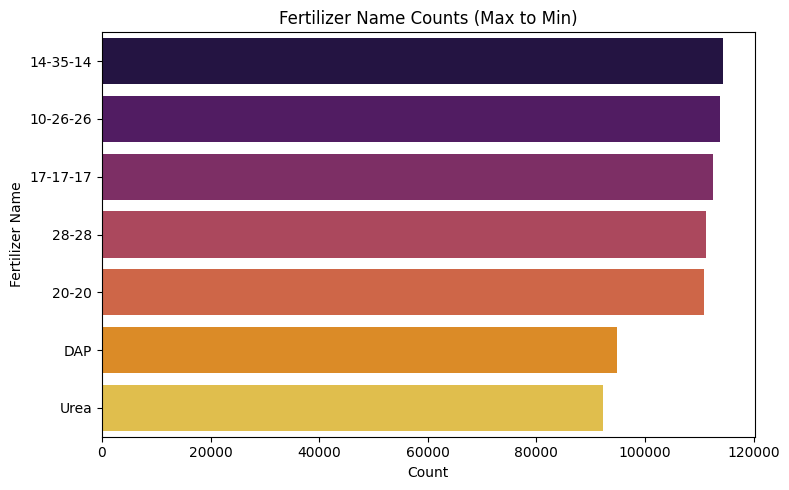

In [80]:
if 'Fertilizer Name' in df.columns:
    fert_counts = df['Fertilizer Name'].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=fert_counts.values, y=fert_counts.index, palette='inferno', hue=fert_counts.index, legend=False)
    plt.xlabel('Count')
    plt.ylabel('Fertilizer Name')
    plt.title('Fertilizer Name Counts (Max to Min)')
    plt.tight_layout()
    plt.show()

# 2. Data Preprocessing

In [81]:
from sklearn.preprocessing import OneHotEncoder

def ohe_and_replace(df, column_name):
    ohe = OneHotEncoder(sparse_output=False)
    encoded = ohe.fit_transform(df[[column_name]]).astype(int)
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out([column_name]))
    col_idx = df.columns.get_loc(column_name)
    df_wo_col = df.drop(column_name, axis=1)
    df = pd.concat([
        df_wo_col.iloc[:, :col_idx].reset_index(drop=True),
        encoded_df.reset_index(drop=True),
        df_wo_col.iloc[:, col_idx:].reset_index(drop=True)
    ], axis=1)
    return df

df = ohe_and_replace(df, 'Soil Type')
df = ohe_and_replace(df, 'Crop Type')

df.head()

,id,Temparature,Humidity,Moisture,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,Soil Type_Red,Soil Type_Sandy,Crop Type_Barley,...,Crop Type_Oil seeds,Crop Type_Paddy,Crop Type_Pulses,Crop Type_Sugarcane,Crop Type_Tobacco,Crop Type_Wheat,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,0,1,0,0,0,0,...,0,0,0,1,0,0,36,4,5,28-28
1,1,27,69,65,0,0,0,0,1,0,...,0,0,0,0,0,0,30,6,18,28-28
2,2,29,63,32,0,0,0,0,1,0,...,0,0,0,0,0,0,24,12,16,17-17-17
3,3,35,62,54,0,0,0,0,1,1,...,0,0,0,0,0,0,39,12,4,10-26-26
4,4,35,58,43,0,0,0,1,0,0,...,0,1,0,0,0,0,37,2,16,DAP
